In [1]:
import pandas as pd

In [2]:
df=pd.read_csv("./PCA_data/AAPL.csv")
df.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,...,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20,Close
0,-1.540483,1.091264,-1.904682,1.023054,-1.610737,-0.457409,-0.976029,-0.176732,-0.435118,0.478131,...,0.594647,-1.798719,0.410359,0.450158,1.018942,-0.555013,-0.408963,-0.376990,0.630134,242.929993
1,-1.482503,1.663316,-2.022443,1.178359,-1.293561,-0.935631,0.196909,0.642453,0.609026,0.982299,...,1.003494,-0.383835,-0.033271,0.560352,0.596939,-0.556418,-0.543539,-0.417217,0.365991,242.789993
2,-1.515986,0.908653,-1.742349,0.279382,-1.786337,-0.621862,0.171432,-0.073792,0.768102,1.199737,...,-0.089080,0.481177,-0.268350,-1.162471,-0.360505,1.451247,-0.649178,-0.160071,0.038219,242.997101
3,-1.507207,1.504773,-1.953247,0.780044,-1.139244,-0.770421,1.994797,1.910108,0.250264,1.109654,...,-1.528903,0.125449,-0.547690,-1.580888,-0.156410,0.334201,-0.736637,0.242141,0.040221,242.919998
4,-1.438237,2.371049,-2.114689,1.259357,-0.693816,-0.986994,0.749530,1.705507,-1.528096,-1.428627,...,1.497952,-0.000800,-0.679917,-0.721003,0.125817,0.350791,-0.594471,-0.229388,0.141762,242.610992


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3385 entries, 0 to 3384
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pca1    3385 non-null   float64
 1   pca2    3385 non-null   float64
 2   pca3    3385 non-null   float64
 3   pca4    3385 non-null   float64
 4   pca5    3385 non-null   float64
 5   pca6    3385 non-null   float64
 6   pca7    3385 non-null   float64
 7   pca8    3385 non-null   float64
 8   pca9    3385 non-null   float64
 9   pca10   3385 non-null   float64
 10  pca11   3385 non-null   float64
 11  pca12   3385 non-null   float64
 12  pca13   3385 non-null   float64
 13  pca14   3385 non-null   float64
 14  pca15   3385 non-null   float64
 15  pca16   3385 non-null   float64
 16  pca17   3385 non-null   float64
 17  pca18   3385 non-null   float64
 18  pca19   3385 non-null   float64
 19  pca20   3385 non-null   float64
 20  Close   3385 non-null   float64
dtypes: float64(21)
memory usage: 555.5 KB

In [4]:
def NaNCheck(data):
  return data.isnull().sum()[data.isnull().sum()>0]

In [6]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import grad as torch_grad
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [7]:
sliding_window_size = 10
# testing_duration = 1600
# training_duration = 1700

In [8]:
use_cuda = 1
cuda = torch.cuda.is_available()
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
print(device)

cuda


## data Preprocess

In [20]:
def preprocess(df):
  # df.index = pd.to_datetime(df['Datetime'])
  cols = list(df)[1:]
  df_for_training = df[cols].astype(float)
  df_for_training =df_for_training.dropna()
  labels_df = df_for_training["Close"]
  features_df = df_for_training.drop(columns=["Close"])

  return features_df,labels_df

## Sliding Window

In [10]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]-4):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i:i+5].flatten()
        tmp_y_gan = y[i - window: i + 5]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = np.array(x_)
    y_ = np.array(y_)
    y_gan = np.array(y_gan)
    return x_, y_, y_gan

## Normalize

In [11]:
def normalize(x,y):
  x_scaler = MinMaxScaler(feature_range = (0, 1))
  y_scaler = MinMaxScaler(feature_range = (0, 1))
  _x = x_scaler.fit_transform(x)

  _y = y_scaler.fit_transform(y.values.reshape(-1, 1))

  return _x, _y

## Split Dataset

In [12]:
def split_dataset(features_df,labels_df,y_gan,training_duration,testing_duration):
    train_x = features_df[:training_duration]
    train_y = labels_df[:training_duration]#.values.reshape(-1,1)
    train_y_gan = y_gan[:training_duration]#.values.reshape(-1,1)

    test_x = features_df[training_duration:training_duration+testing_duration]
    test_y = labels_df[training_duration:training_duration+testing_duration]#.values.reshape(-1,1)
    test_y_gan = y_gan[training_duration:training_duration+testing_duration]#.values.reshape(-1,1)

    print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
    print(f'testX: {test_x.shape} testY: {test_y.shape}')

    train_x = torch.from_numpy(np.array(train_x)).float()
    train_y = torch.from_numpy(np.array(train_y)).float()
    train_y_gan = torch.from_numpy(np.array(train_y_gan)).float()
    test_x = torch.from_numpy(np.array(test_x)).float()
    test_y = torch.from_numpy(np.array(test_y)).float()
    test_y_gan = torch.from_numpy(np.array(test_y_gan)).float()


    return train_x,train_y,train_y_gan,test_x,test_y,test_y_gan

## Train Test Split

In [8]:
# labels_df = df["Close"]
# features_df = df.drop(columns=["Close"])

# train_x = features_df.iloc[:training_duration]
# train_y = labels_df.iloc[:training_duration]

# test_x = features_df.iloc[training_duration:training_duration+testing_duration]
# test_y = labels_df.iloc[training_duration:training_duration+testing_duration]

# print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
# print(f'testX: {test_x.shape} testY: {test_y.shape}')

trainX: (1700, 20) trainY: (1700,)
testX: (1600, 20) testY: (1600,)


In [9]:
# x_scaler = MinMaxScaler(feature_range = (0, 1))
# y_scaler = MinMaxScaler(feature_range = (0, 1))

# train_x = x_scaler.fit_transform(train_x)
# test_x = x_scaler.transform(test_x)

# train_y = y_scaler.fit_transform(train_y.values.reshape(-1, 1))
# test_y = y_scaler.transform(test_y.values.reshape(-1, 1))

In [10]:
# print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
# print(f'testX: {test_x.shape} testY: {test_y.shape}')

trainX: (1700, 20) trainY: (1700, 1)
testX: (1600, 20) testY: (1600, 1)


In [11]:
# train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, sliding_window_size)
# test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, sliding_window_size)
# print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
# print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')

train_x: torch.Size([1690, 10, 20]) train_y: torch.Size([1690, 1]) train_y_gan: torch.Size([1690, 11, 1])
test_x: torch.Size([1590, 10, 20]) test_y: torch.Size([1590, 1]) test_y_gan: torch.Size([1590, 11, 1])


## WGAN-GP Model Implementation

In [13]:
class Generator(nn.Module):
  def __init__(self, input_size):
    super().__init__()

    # 3 GRU layers, input_size = features
    self.gru_1 = nn.GRU(input_size, 1024, batch_first=True)
    self.gru_2 = nn.GRU(1024, 512, batch_first = True)
    self.gru_3 = nn.GRU(512, 256, batch_first = True)

    #output for the classification model
    self.gru_4 = nn.GRU(256, 128, batch_first = True)

    # 3 Dense Layers
    self.linear_1 = nn.Linear(256, 128)
    self.linear_2 = nn.Linear(128, 64)
    self.linear_3 = nn.Linear(64, 5)

    self.dropout = nn.Dropout(0.3)


  def forward(self, x):
    use_cuda = 1
    device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
    h0 = torch.zeros(1, x.size(0), 1024).to(device) # initial hidden state for the 1st GRU Layer - (num of layers in the GRU, batch size, num of hidden units in the GRU)
    out_gru_1, _ = self.gru_1(x, h0)
    out_gru_1 = self.dropout(out_gru_1)

    h1 = torch.zeros(1, x.size(0), 512).to(device)
    out_gru_2, _ = self.gru_2(out_gru_1, h1)
    out_gru_2 = self.dropout(out_gru_2)

    h2 = torch.zeros(1, x.size(0), 256).to(device)
    out_gru_3, _ = self.gru_3(out_gru_2, h2)
    out_gru_3 = self.dropout(out_gru_3)

    h3 = torch.zeros(1, x.size(0), 128).to(device)
    out_gru_4, _ = self.gru_4(out_gru_3, h3)
    out_gru_4 = self.dropout(out_gru_4)

    out_dense_1 = self.linear_1(out_gru_3[:, -1, :])
    out_dense_2 = self.linear_2(out_dense_1)
    out_dense_3 = self.linear_3(out_dense_2)
    
    return out_dense_3, out_gru_4

In [15]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    # 3 1D Conv layers
    self.conv1 = nn.Conv1d(sliding_window_size+5, 32, kernel_size = 5, stride = 1, padding = 'same')
    self.conv2 = nn.Conv1d(32, 64, kernel_size = 5, stride = 1, padding = 'same')
    self.conv3 = nn.Conv1d(64, 128, kernel_size = 5, stride = 1, padding = 'same')

    # 3 linear layers
    self.linear1 = nn.Linear(128, 220)
    self.linear2 = nn.Linear(220, 220)
    self.linear3 = nn.Linear(220, 5)

    self.leaky = nn.LeakyReLU(0.01)
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()

  def forward(self, x):
    conv1 = self.conv1(x)
    conv1 = self.leaky(conv1)
    conv2 = self.conv2(conv1)
    conv2 = self.leaky(conv2)
    conv3 = self.conv3(conv2)
    conv3 = self.leaky(conv3)

    flatten_x =  conv3.reshape(conv3.shape[0], conv3.shape[1])

    out_1 = self.linear1(flatten_x)
    out_1 = self.leaky(out_1)
    out_2 = self.linear2(out_1)
    out_2 = self.relu(out_2)
    out_3 = self.linear3(out_2)

    return out_3

In [16]:
def grad_penalty_fnc(real_data, gen_data,D,cuda,gp_weight):
    batch_size = real_data.size()[0]
    t = torch.rand((batch_size, 1, 1), requires_grad=True)
    t = t.expand_as(real_data)

    if cuda:
        t = t.cuda()

    # mixed sample from real and fake; make approx of the 'true' gradient norm
    interpol = t * real_data.data + (1-t) * gen_data.data

    if cuda:
        interpol = interpol.cuda()
    prob_interpol = D(interpol)
    torch.autograd.set_detect_anomaly(True)
    gradients = torch_grad(outputs=prob_interpol, inputs=interpol,
                           grad_outputs=torch.ones(prob_interpol.size()).cuda() if cuda else torch.ones(
                               prob_interpol.size()), create_graph=True, retain_graph=True)[0]
    gradients = gradients.view(batch_size, -1)
    #grad_norm = torch.norm(gradients, dim=1).mean()
    #self.losses['gradient_norm'].append(grad_norm.item())

    # add epsilon for stability
    eps = 1e-10
    gradients_norm = torch.sqrt(torch.sum(gradients**2, dim=1, dtype=torch.double) + eps)
    #gradients = gradients.cpu()
    # comment: precision is lower than grad_norm (think that is double) and gradients_norm is float
    final = gp_weight * (torch.max(torch.zeros(1,dtype=torch.double).cuda() if cuda else torch.zeros(1,dtype=torch.double), gradients_norm.mean() - 1) ** 2), gradients_norm.mean().item()
    return final

## Model Training

In [17]:
def train(train_x_slide,train_y_gan,scaled_x,sliding_window_size,device,cuda):
  batch_size = 128
  learning_rate = 0.000115
  num_epochs = 100
  critic_iterations = 5
#   eraly_exit = 10
#   treshold = 0.1
#   count = 0

  trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = False)

  # Give number of features to the G
  modelG = Generator(scaled_x.shape[1]).to(device)
  modelD = Discriminator().to(device)

  #weight_decay-L2 penalty to the weights
  optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate, betas = (0.0, 0.9), weight_decay = 1e-3)
  optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate, betas = (0.0, 0.9), weight_decay = 1e-3)

  # optimizerG = torch.optim.RMSprop(modelG.parameters(), lr = learning_rate, weight_decay = 1e-3)
  # optimizerD = torch.optim.RMSprop(modelD.parameters(), lr = learning_rate, weight_decay = 1e-3)

  histG = np.zeros(num_epochs)
  histD = np.zeros(num_epochs)
  count = 0

  #k=0
  i=0
  for epoch in range(num_epochs):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
      x = x.to(device)
      y = y.to(device)

      fake_data,_ = modelG(x)
#         print(y.shape,fake_data.shape)
#         print(y[:, :sliding_window_size, :].shape, fake_data.reshape(-1, 1, 1).shape)
      i=1
      fake_data = torch.cat([y[:, :sliding_window_size, :], fake_data.reshape(-1, 5, 1)], axis = 1)

      for _ in range(critic_iterations):
        critic_real = modelD(y)
        critic_fake = modelD(fake_data)
        grad_penalty, grad_norm_ = grad_penalty_fnc(y, fake_data,modelD,cuda,10)
        # Take probability mean of whole batch.
        lossD = -(torch.mean(critic_real) - torch.mean(critic_fake)) + grad_penalty

        modelD.zero_grad()
        lossD.backward(retain_graph = True)
        optimizerD.step()

      output_fake = modelD(fake_data)
      lossG = -torch.mean(output_fake)

      modelG.zero_grad() # zeroing the gradients
      lossG.backward() # computing the gradients
      optimizerG.step() # updating the parameters

      loss_D.append(lossD.item())
      loss_G.append(lossG.item())

    histG[epoch] = sum(loss_G)
    histD[epoch] = sum(loss_D)

    # Check if the loss exceeds the threshold
#     if sum(loss_D) > treshold:
#         count+=1
#         if count>= eraly_exit:
#             print(f'Early exit at epoch {epoch+1} due to loss exceeding the threshold.')
#             break
    print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')
  return modelG

## Model Evaluation

In [18]:
def evaluateModel(modelG,train_x_slide,test_x_slide,train_y_slide,test_y_slide):
  modelG.eval()
  pred_y_train,_ = modelG(train_x_slide.to(device))
  pred_y_test,_ = modelG(test_x_slide.to(device))


  y_train_true =train_y_slide
  y_train_pred = pred_y_train.cpu().detach().numpy()

  y_test_true = test_y_slide
  y_test_pred = pred_y_test.cpu().detach().numpy()

  plt.figure(figsize=(12, 8))
  plt.plot(y_train_true, color = 'black', label = 'Acutal Price')
  plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
  plt.title('WGAN-GP prediction training dataset')
  plt.ylabel('BTC')
  plt.xlabel('5 min time periods')
  plt.legend(loc = 'upper right')

  MSE = mean_squared_error(y_train_true, y_train_pred)
  RMSE = math.sqrt(MSE)
  print(f'Training dataset RMSE:{RMSE}')


  plt.figure(figsize=(12, 8))
  plt.plot(y_test_true, color = 'black', label = 'Acutal Price')
  plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
  plt.title('WGAN-GP prediction testing dataset')
  plt.ylabel('BTC')
  plt.xlabel('5 min time periods')
  plt.legend(loc = 'upper right')

  MSE = mean_squared_error(y_test_true, y_test_pred)
  RMSE = math.sqrt(MSE)
  print(f'Testing dataset RMSE:{RMSE}')

In [21]:
# #parameters
# sliding_window_size = 10
# # testing_duration = 2016
# # training_duration = 2016*3

features_df,labels_df =preprocess(df)

# # Dimentional Reduction
# num_components = 31
# pca = PCA(num_components)
# features_df_pca = pca.fit_transform(features_df) # fit and reduce dimension

In [22]:
dataset_size= features_df.shape[0]
print("Full dataset size: ",dataset_size)
testing_duration = int(dataset_size*0.3)
training_duration = int(dataset_size*0.7)

Full dataset size:  3385


In [23]:
scaled_x,scaled_y = normalize(features_df,labels_df)

In [24]:
x_slide, y_slide, y_gan = sliding_window(scaled_x, scaled_y, sliding_window_size)
print(f'train_x: {x_slide.shape} train_y: {y_slide.shape} train_y_gan: {y_gan.shape}')

train_x: (3371, 10, 19) train_y: (3371, 5) train_y_gan: (3371, 15, 1)


In [26]:
train_x_slide,train_y_slide,train_y_gan,test_x_slide,test_y_slide,test_y_gan = split_dataset(x_slide, y_slide, y_gan,training_duration,testing_duration)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')

trainX: (2369, 10, 19) trainY: (2369, 5)
testX: (1002, 10, 19) testY: (1002, 5)
train_x: torch.Size([2369, 10, 19]) train_y: torch.Size([2369, 5]) train_y_gan: torch.Size([2369, 15, 1])
test_x: torch.Size([1002, 10, 19]) test_y: torch.Size([1002, 5]) test_y_gan: torch.Size([1002, 15, 1])


In [27]:
modelG = train(train_x_slide,train_y_gan,scaled_x,sliding_window_size,device,cuda)

c:\Users\usith\anaconda3\Lib\site-packages\torch\autograd\graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[1/100] LossD: -0.1299525197246112 LossG:-0.2115887037361972
[2/100] LossD: -0.12294068746268749 LossG:-1.1200770903378725
[3/100] LossD: -0.0329687874764204 LossG:-0.7005070075392723
[4/100] LossD: -0.0031676292419433594 LossG:-0.5233990792185068
[5/100] LossD: -0.033261945471167564 LossG:-0.44398690667003393
[6/100] LossD: -0.2220474686473608 LossG:-0.4871253753080964
[7/100] LossD: -0.5933752050623298 LossG:-0.29491498635616153
[8/100] LossD: -1.2507821899813594 LossG:-0.1793355755507946
[9/100] LossD: -1.2166448662527658 LossG:-0.47105916077271104
[10/100] LossD: -1.3263789186573463 LossG:-0.49255979317240417
[11/100] LossD: -1.357805520556394 LossG:-0.3723015673458576
[12/100] LossD: -1.3755477473062911 LossG:-0.3674655584618449
[13/100] LossD: -1.3983453885881882 LossG:-0.4980371027486399
[14/100] LossD: -1.3945745584999842 LossG:-0.3861339323921129
[15/100] LossD: -1.410034282506749 LossG:-0.1507248416019138
[16/100] LossD: -1.3055619405366006 LossG:-0.16760657085103503
[17/100]

Training dataset RMSE:0.4555082130675717
Testing dataset RMSE:0.14547891777962718


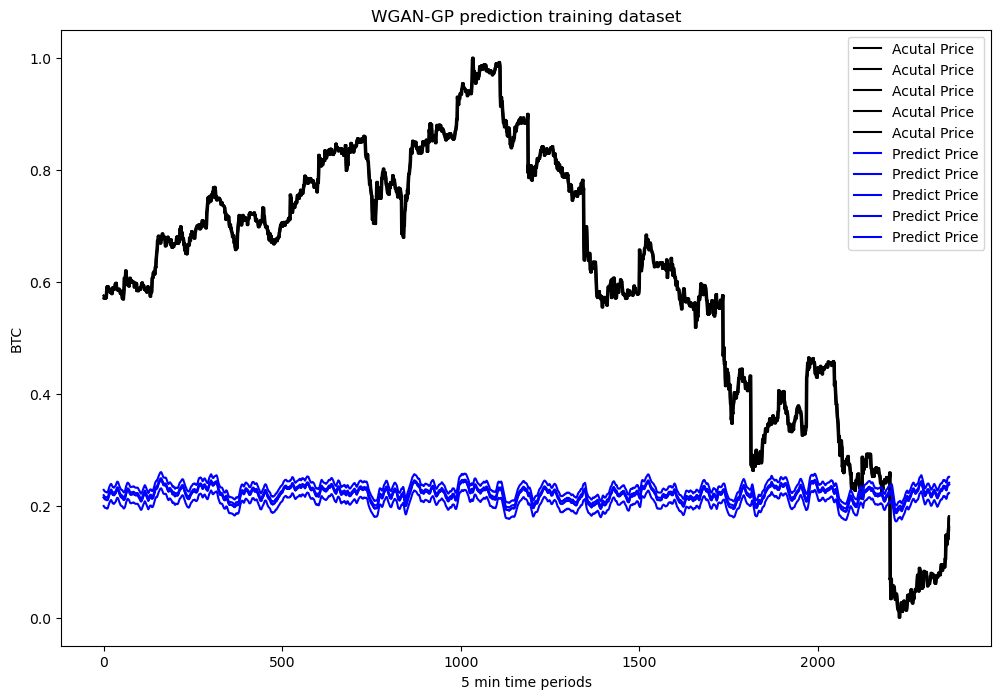

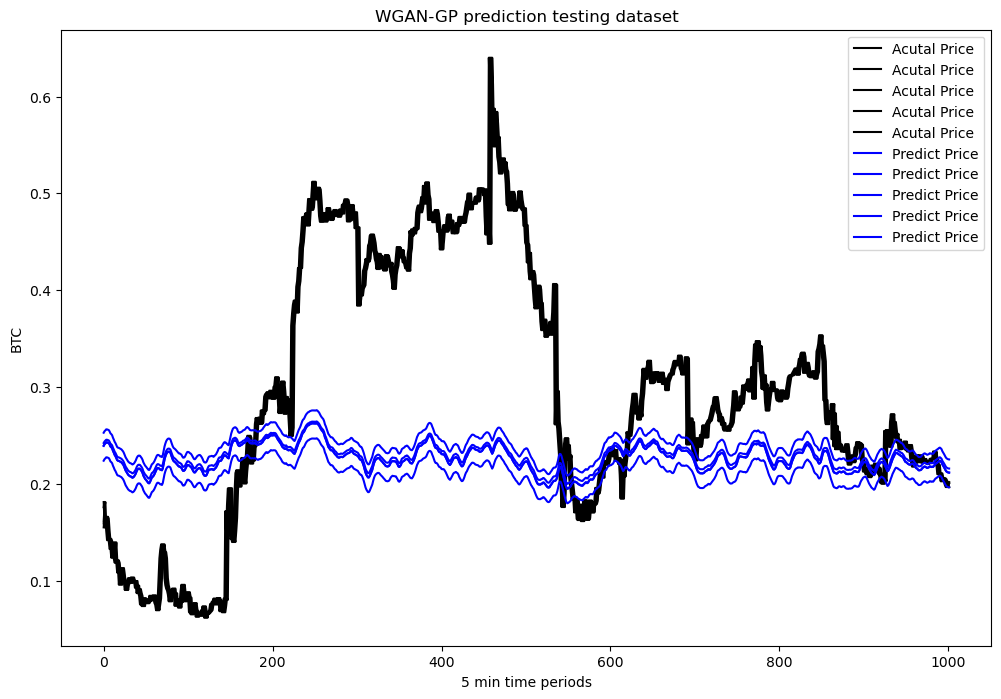

In [28]:
evaluateModel(modelG,train_x_slide,test_x_slide,train_y_slide,test_y_slide)

In [29]:
#Get predictions to the full dataset
concatenated_array = np.concatenate((train_x_slide,test_x_slide), axis=0)
# Convert NumPy array to PyTorch tensor
concatenated_tensor = torch.tensor(concatenated_array, dtype=torch.float32).to(device)
# Forward pass through the model
all_predictions, gru_layer = modelG(concatenated_tensor)

## XGBoost input preprocess

In [30]:
def xgb_input(train_input_features):
  # Create column names for features
  feature_names = [f"X_feature_{i}" for i in range(train_input_features.shape[1])]

  # Combine column names
  column_names = feature_names

  # Move the tensor to the CPU before converting to NumPy
  train_input_features_cpu = train_input_features.cpu().detach().numpy()

  # Create a DataFrame with the concatenated array and column names
  features_df = pd.DataFrame(train_input_features_cpu, columns=column_names)

  # Specify the path where you want to save the CSV file
  csv_path = "gan_output.csv"

  # Save the DataFrame to a CSV file
  features_df.to_csv(csv_path, index=False)

## Elliott input preprocess

In [31]:
def nn_input(concatenated_original,all_predictions_original):
  # Get the last five values in each row of x_test1
  last_five_values_x_test1 = concatenated_original[:,-5:,0]
  # Create a DataFrame with the last five values and predicted values
  data = {'X_test1_Last_1': last_five_values_x_test1[:, 0],
          'X_test1_Last_2': last_five_values_x_test1[:, 1],
          'X_test1_Last_3': last_five_values_x_test1[:, 2],
          'X_test1_Last_4': last_five_values_x_test1[:, 3],
          'X_test1_Last_5': last_five_values_x_test1[:, 4],
          'Predicted_1': all_predictions_original[:, 0],
          'Predicted_2': all_predictions_original[:, 1],
          'Predicted_3': all_predictions_original[:, 2],
          'Predicted_4': all_predictions_original[:, 3],
          'Predicted_5': all_predictions_original[:, 4]}

  df = pd.DataFrame(data)

  # Specify the path where you want to save the CSV file
  csv_path = "output_file.csv"

  # Save the DataFrame to a CSV file
  df.to_csv(csv_path, index=False)

In [32]:
train_input_features = gru_layer.reshape(gru_layer.shape[0], -1)
xgb_input(train_input_features)

labels_df = labels_df.to_numpy(dtype=float)
features_df = features_df.to_numpy(dtype=float)

original,_,_= sliding_window(features_df,labels_df,10)
original = original[:training_duration+testing_duration]

all_predictions_cpu = all_predictions.cpu().detach()
# Convert to NumPy array
all_predictions_numpy = all_predictions_cpu.numpy()
nn_input(original,all_predictions_numpy)

In [16]:
# batch_size = 128
# learning_rate = 0.00005
# num_epochs = 1000
# critic_iterations = 10

# trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = False)

# # Give number of features to the G
# modelG = Generator(train_x.shape[1]).to(device)
# modelD = Discriminator().to(device)

# #weight_decay-L2 penalty to the weights
# optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate, betas = (0.0, 0.9), weight_decay = 1e-3)
# optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate, betas = (0.0, 0.9), weight_decay = 1e-3)

# # optimizerG = torch.optim.RMSprop(modelG.parameters(), lr = learning_rate, weight_decay = 1e-3)
# # optimizerD = torch.optim.RMSprop(modelD.parameters(), lr = learning_rate, weight_decay = 1e-3)

# histG = np.zeros(num_epochs)
# histD = np.zeros(num_epochs)
# count = 0

# #k=0
# i=0
# for epoch in range(num_epochs):
#     loss_G = []
#     loss_D = []
#     for (x, y) in trainDataloader:
#         x = x.to(device)
#         y = y.to(device)
    
#         fake_data = modelG(x)
#         i=1
#         fake_data = torch.cat([y[:, :sliding_window_size, :], fake_data.reshape(-1, 1, 1)], axis = 1)
        
#         for _ in range(critic_iterations):
#             critic_real = modelD(y)
#             critic_fake = modelD(fake_data)
#             grad_penalty, grad_norm_ = grad_penalty_fnc(y, fake_data,modelD,cuda,5)
#             # Take probability mean of whole batch.
#             lossD = -(torch.mean(critic_real) - torch.mean(critic_fake)) + grad_penalty

#             modelD.zero_grad()
#             lossD.backward(retain_graph = True)
#             optimizerD.step()
    
#         output_fake = modelD(fake_data)
#         lossG = -torch.mean(output_fake)

#         modelG.zero_grad() # zeroing the gradients
#         lossG.backward() # computing the gradients
#         optimizerG.step() # updating the parameters

#         loss_D.append(lossD.item())
#         loss_G.append(lossG.item())
    
#     histG[epoch] = sum(loss_G) 
#     histD[epoch] = sum(loss_D)
#     print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')

c:\Users\usith\anaconda3\Lib\site-packages\torch\autograd\graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[1/1000] LossD: -0.04685521312057972 LossG:0.3982682414352894
[2/1000] LossD: -0.3159896917641163 LossG:0.5614676643162966
[3/1000] LossD: 0.06635165959596634 LossG:0.4884118065237999
[4/1000] LossD: 0.006230127066373825 LossG:0.34417747892439365
[5/1000] LossD: -0.02989506721496582 LossG:0.39093962125480175
[6/1000] LossD: -0.03088395856320858 LossG:0.4192430730909109
[7/1000] LossD: -0.08935676328837872 LossG:0.5066474284976721
[8/1000] LossD: -0.23132827342487872 LossG:0.602459317073226
[9/1000] LossD: -0.5178138166666031 LossG:0.4746154975146055
[10/1000] LossD: -1.1838056249544024 LossG:0.773153462447226
[11/1000] LossD: -2.1959211188657815 LossG:1.1920070764608681
[12/1000] LossD: -2.263501111489677 LossG:0.850777605548501
[13/1000] LossD: -2.1901668337732585 LossG:0.6253638137131929
[14/1000] LossD: -2.061931681231422 LossG:0.34981484804302454
[15/1000] LossD: -1.8612831303383772 LossG:0.061122210463508964
[16/1000] LossD: -1.66129061307862 LossG:-0.07110647670924664
[17/1000] L

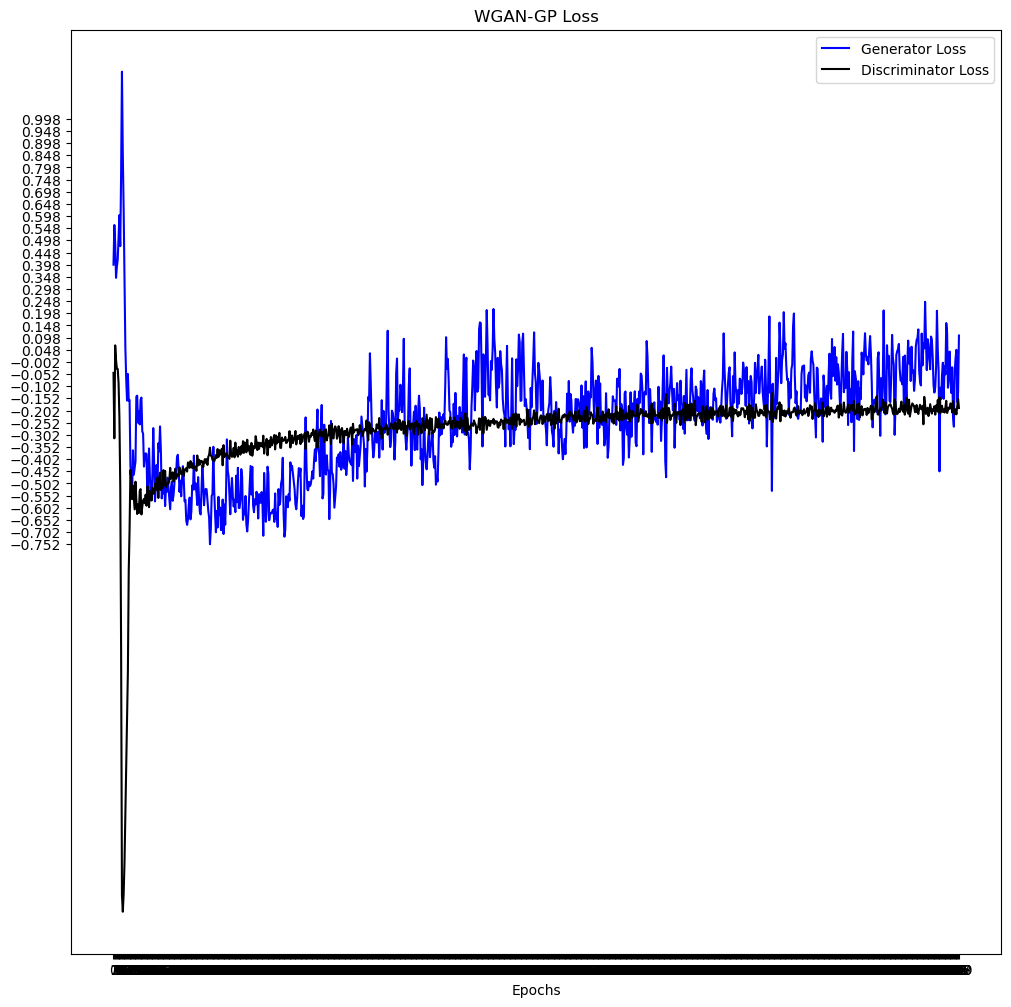

In [17]:
# plt.figure(figsize = (12, 12))
# plt.plot(histG, color = 'blue', label = 'Generator Loss')
# plt.plot(histD, color = 'black', label = 'Discriminator Loss')
# plt.xticks(np.arange(0, num_epochs, 1.0))
# plt.yticks(np.arange(min(histG), 1, 0.05))
# plt.title('WGAN-GP Loss')
# plt.xlabel('Epochs')
# plt.legend(loc = 'upper right')

In [18]:
# train_y_slide.shape

torch.Size([1690, 1])

In [19]:
# modelG.eval()
# pred_y_train = modelG(train_x_slide.to(device))
# pred_y_test = modelG(test_x_slide.to(device))

# y_train_true = y_scaler.inverse_transform(train_y_slide)
# y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

# y_test_true = y_scaler.inverse_transform(test_y_slide)
# y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:0.7278940865555955


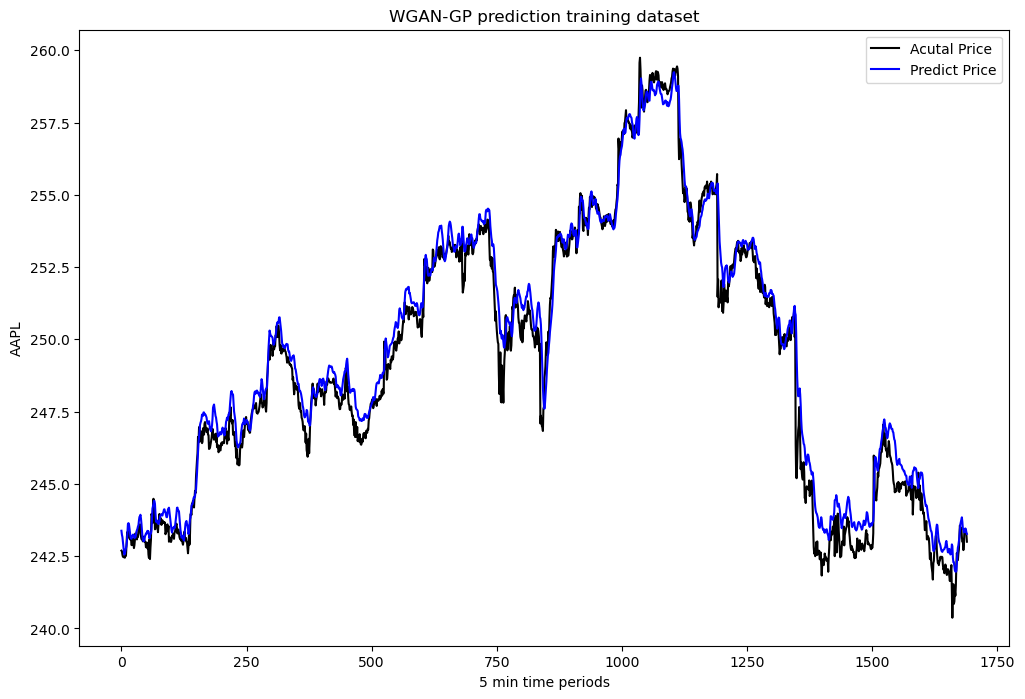

In [20]:
# plt.figure(figsize=(12, 8))
# plt.plot(y_train_true, color = 'black', label = 'Acutal Price')
# plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
# plt.title('WGAN-GP prediction training dataset')
# plt.ylabel('AAPL')
# plt.xlabel('5 min time periods')
# plt.legend(loc = 'upper right')

# MSE = mean_squared_error(y_train_true, y_train_pred)
# RMSE = math.sqrt(MSE)
# print(f'Training dataset RMSE:{RMSE}')

Testing dataset RMSE:1.8940390931903435


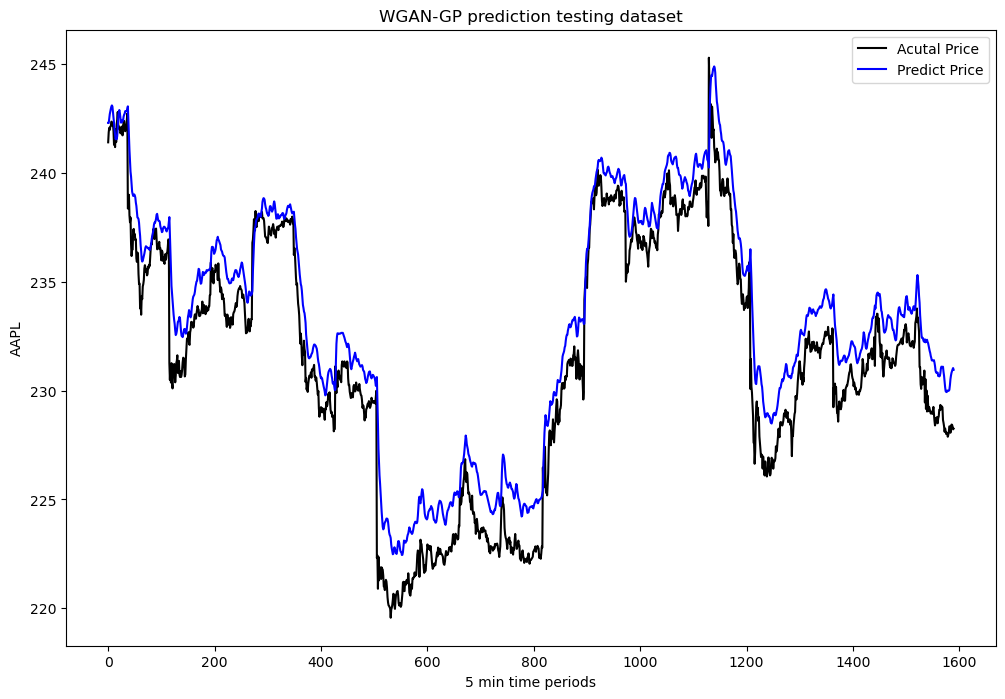

In [21]:
# plt.figure(figsize=(12, 8))
# plt.plot(y_test_true, color = 'black', label = 'Acutal Price')
# plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
# plt.title('WGAN-GP prediction testing dataset')
# plt.ylabel('AAPL')
# plt.xlabel('5 min time periods')
# plt.legend(loc = 'upper right')

# MSE = mean_squared_error(y_test_true, y_test_pred)
# RMSE = math.sqrt(MSE)
# print(f'Testing dataset RMSE:{RMSE}')

In [23]:
import os
import torch

root = os.getcwd()
output_folder_models = os.path.join(root, "Trained_models")  # Folder to save feature engineered files

# Ensure output folder exists
os.makedirs(output_folder_models, exist_ok=True)

# Define file paths for saving
generator_path = os.path.join(output_folder_models, "WGAN_Generator.pth")
discriminator_path = os.path.join(output_folder_models, "WGAN_Discriminator.pth")

# Save the trained models
torch.save({
    'epoch': num_epochs,
    'model_state_dict': modelG.state_dict(),
    'optimizer_state_dict': optimizerG.state_dict(),
    'loss_history': histG  # Save loss history for analysis
}, generator_path)

torch.save({
    'epoch': num_epochs,
    'model_state_dict': modelD.state_dict(),
    'optimizer_state_dict': optimizerD.state_dict(),
    'loss_history': histD  # Save loss history for analysis
}, discriminator_path)

print("Models saved successfully!")


Models saved successfully!


In [24]:
# # Define file paths
# generator_path = "WGAN_Generator.pth"
# discriminator_path = "WGAN_Discriminator.pth"

# Initialize model instances (same architecture)
modelG = Generator(train_x.shape[1]).to(device)
modelD = Discriminator().to(device)

# Load the trained model state
checkpoint_G = torch.load(generator_path)
checkpoint_D = torch.load(discriminator_path)

# Restore state dict (weights)
modelG.load_state_dict(checkpoint_G['model_state_dict'])
modelD.load_state_dict(checkpoint_D['model_state_dict'])

# Restore optimizers (if continuing training)
optimizerG.load_state_dict(checkpoint_G['optimizer_state_dict'])
optimizerD.load_state_dict(checkpoint_D['optimizer_state_dict'])

# Get last epoch
last_epoch = checkpoint_G['epoch']

print(f"Models loaded successfully! Last trained epoch: {last_epoch}")


C:\Users\usith\AppData\Local\Temp\ipykernel_33736\1535091488.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_G = torch.load(generator_path)


Models loaded successfully! Last trained epoch: 1000


C:\Users\usith\AppData\Local\Temp\ipykernel_33736\1535091488.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_D = torch.load(discriminator_path)


In [25]:
modelG.eval()  # Set to evaluation mode

# Example: Generate fake market prices from input `x`
with torch.no_grad():
    fake_prices = modelG(x.to(device))

print(fake_prices)


tensor([[0.0926],
        [0.0843],
        [0.0823],
        [0.0821],
        [0.0834],
        [0.0974],
        [0.1149],
        [0.1252],
        [0.1291],
        [0.1367],
        [0.1429],
        [0.1567],
        [0.1671],
        [0.1710],
        [0.1740],
        [0.1792],
        [0.1707],
        [0.1588],
        [0.1584],
        [0.1525],
        [0.1526],
        [0.1538],
        [0.1594],
        [0.1576],
        [0.1526],
        [0.1498]], device='cuda:0')
